In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from pdbbind_metadata_processor import PDBBindMetadataProcessor

In [2]:
pdbbind_table = PDBBindMetadataProcessor().get_master_dataframe()

In [3]:
pdbbind_table.head()

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG),"[mM, =, 400]",=,400000000.0,nM,2012,Q01217,ACETYLGLUTAMATE KINASE,False
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX),"[mM, =, 355]",=,355000000.0,nM,2009,O67854,TRANSPORTER,False
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3),"[mM, =, 320]",=,320000000.0,nM,2004,P62937,PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A,False
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP),"[mM, =, 320]",=,320000000.0,nM,2009,P24630,"GLUTAMATE-1-SEMIALDEHYDE 2,1-AMINOMUTASE",False
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM),"[mM, =, 250]",=,250000000.0,nM,1996,P00918,CARBONIC ANHYDRASE 2,False


In [4]:
smiles_df = pd.read_csv('data/smiles_df.csv', index_col=0)

In [5]:
smiles_df.head()

,smiles,dataset,id,included
0,CC[C@H]1[C@@H](C(=O)N[C@]2(C(=O)NS(=O)(=O)C3(C...,pdbbind,6nzt,False
1,Cc1ccc(NC(=O)N[C@@H](Cc2cc(F)cc(F)c2)C(=O)N[C@...,pdbbind,6pka,False
2,O=c1ncc2c(-c3ccc(F)cc3F)cc(N3CC[NH2+]CC3)cc2n1...,pdbbind,1m7q,True
3,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,pdbbind,5vwk,False
4,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,pdbbind,5vwi,False


In [6]:
included_pdb_ids = smiles_df[(smiles_df['included']) & (smiles_df['dataset'] == 'pdbbind')]['id'].unique()

In [7]:
included_table = pdbbind_table[pdbbind_table['PDB code'].isin(included_pdb_ids)]

In [8]:
from chembl_connector import ChEMBLConnector
cc = ChEMBLConnector()
chembl_target_df = cc.get_target_table(level=3)
chembl_target_df.head()

,accession,component_synonym,protein_class_desc,level3,gene_symbol_lowercase
0,O09028,Gabrp,ion channel lgic gabaa,ion channel lgic gabaa,gabrp
1,P02708,CHRNA1,ion channel lgic ach chrn alpha,ion channel lgic ach,chrna1
2,P04637,TP53,transcription factor,transcription factor,tp53
3,P04757,Chrna3,ion channel lgic ach chrn alpha,ion channel lgic ach,chrna3
4,P05106,ITGB3,membrane receptor,membrane receptor,itgb3


In [9]:
included_table = included_table.merge(chembl_target_df, left_on='Uniprot ID', right_on='accession')

In [10]:
included_table['level3'].value_counts()[:5]

enzyme  kinase  protein kinase    2784
enzyme  transferase               1006
enzyme  hydrolase                  866
enzyme  protease  serine           731
enzyme  lyase                      549
Name: level3, dtype: int64

In [11]:
def get_target_mol_results(gene_symbol, mol_results) :
    all_results = {}
    target_pdb_ids = included_table[included_table['gene_symbol_lowercase'] == gene_symbol]['PDB code']
    ligand_smiles = smiles_df[smiles_df['id'].isin(target_pdb_ids)]['smiles'].unique()
    for smiles in ligand_smiles :
        if smiles in mol_results :
            all_results[smiles] = mol_results[smiles]
    return all_results

In [12]:
def group_target_results(all_results) :
    target_results = defaultdict(list)
    for smiles, result in all_results.items() :
        if 'normalized_first_bioactive_rank' in result :
            for key in result.keys() :
                value = result[key]
                if type(value) in [int, float, np.float64] :
                    target_results[key].append(value)
            normalized_first_bioactive_rank_model = result['normalized_first_bioactive_rank']['model']
            target_results['normalized_first_bioactive_rank_model'].append(normalized_first_bioactive_rank_model)
    return target_results

In [13]:
def get_results(split, iteration) :
    mol_results_path = f'results/{split}_split_{iteration}_pdbbind/mol_results.p'
    with open(mol_results_path, 'rb') as f :
        mol_results = pickle.load(f)
    return mol_results

In [14]:
def get_training_pdbs(split, iteration) :
    
    if split in ['random', 'scaffold'] :
        train_smiles_path = f'data/ligand_{split}_splits/train_smiles_{split}_split_{iteration}.txt'
        with open(train_smiles_path, 'r') as f :
            train_smiles = f.readlines()
            train_smiles = [s.strip() for s in train_smiles]
        train_pdbs = smiles_df[smiles_df['smiles'].isin(train_smiles)]['id'].unique()
        
    elif split in ['protein'] :
        train_pdbs_path = f'data/protein_similarity_splits/train_pdb_protein_similarity_split_{iteration}.txt'
        with open(train_pdbs_path, 'r') as f :
            train_pdbs = f.readlines()
            train_pdbs = [s.strip() for s in train_pdbs]
            
    return train_pdbs

In [15]:
def get_training_size(gene_symbol, train_pdbs) :
    filtered_table = included_table[(included_table['PDB code'].isin(train_pdbs)) & (included_table['gene_symbol_lowercase'] == gene_symbol)]
    return len(filtered_table)

In [16]:
def get_target_grouped_results(split, iteration) :
    mol_results = get_results(split, iteration)
    target_grouped_results = defaultdict(list)
    for gene_symbol in included_table['gene_symbol_lowercase'].unique() :

        all_results = get_target_mol_results(gene_symbol, mol_results)
        target_results = group_target_results(all_results)

        if len(target_results) :

            ranks = target_results['normalized_first_bioactive_rank_model']
            median = np.median(ranks)
            n_first = len([True for rank in ranks if rank == 0])
            fraction_bioactive_first = n_first / len(ranks)
            train_pdbs = get_training_pdbs(split, iteration)
            training_set_size = get_training_size(gene_symbol, train_pdbs)
            target_grouped_results['gene_symbol'].append(gene_symbol)
            target_grouped_results['fraction_bio_first'].append(fraction_bioactive_first)
            target_grouped_results['training_set_size'].append(training_set_size)
            target_grouped_results['median_rank'].append(median)
            target_grouped_results['test_set_size'].append(len(ranks))
            target_grouped_results['split'] = split
            target_grouped_results['iteration'] = iteration
    return target_grouped_results

In [17]:
splits = ['random', 'scaffold', 'protein']
iterations = range(5)
master_df = pd.DataFrame()
for split in splits :
    for iteration in iterations :
        target_grouped_results = get_target_grouped_results(split, iteration)
        target_df = pd.DataFrame(target_grouped_results)
        master_df = master_df.append(target_df, ignore_index=True)

<AxesSubplot:xlabel='median_rank', ylabel='split'>

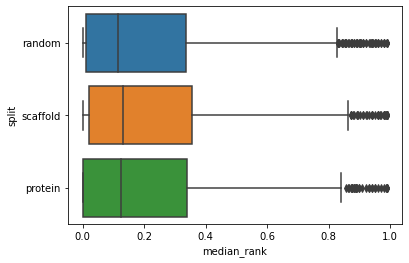

In [18]:
sns.boxplot(data=master_df, y='split', x='median_rank')

In [19]:
master_df.groupby(['gene_symbol', 'split']).mean().to_csv('target_specific_performances.csv')

In [20]:
gene_counts = master_df['gene_symbol'].value_counts()
gene_counts[gene_counts == 15]

ttk       15
hdac8     15
pim1      15
mapk1     15
gsk3b     15
bla       15
syk       15
dot1l     15
chek1     15
itk       15
src       15
ttr       15
cdk2      15
ampc      15
pdpk1     15
prkaca    15
Name: gene_symbol, dtype: int64

In [21]:
dude_targets = os.listdir('../DUD-E/all/')

In [22]:
target_spec_df = master_df[(master_df['gene_symbol'].isin(dude_targets)) & (master_df['split'] == 'protein')].sort_values('gene_symbol')

In [23]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(target_spec_df)

In [24]:
master_df[master_df['gene_symbol'] == 'jak2']

,gene_symbol,fraction_bio_first,training_set_size,median_rank,test_set_size,split,iteration
149,jak2,0.400000,106,0.010204,5,random,0
513,jak2,0.428571,96,0.009901,7,random,1
892,jak2,0.400000,92,0.039604,10,random,2
1272,jak2,0.333333,108,0.049505,3,random,3
1666,jak2,0.142857,98,0.069307,7,random,4
2024,jak2,0.142857,104,0.289474,7,scaffold,0
2385,jak2,0.166667,102,0.059406,6,scaffold,1
2716,jak2,0.571429,96,0.000000,7,scaffold,2
3037,jak2,0.333333,106,0.149752,6,scaffold,3
3363,jak2,0.375000,108,0.168317,8,scaffold,4


<AxesSubplot:xlabel='median_rank', ylabel='gene_symbol'>

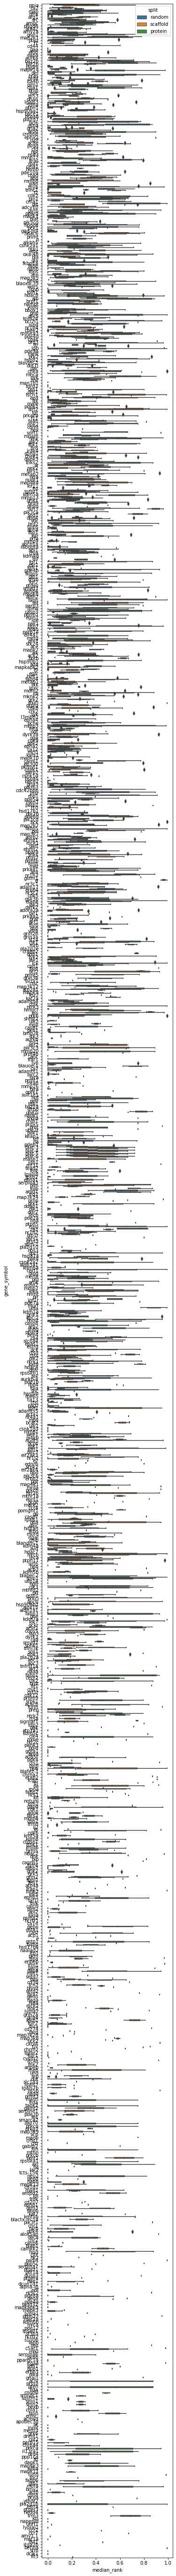

In [22]:
plt.figure(figsize=(5, 100))
sns.boxplot(data=master_df, y='gene_symbol', x='median_rank', hue='split')